# ALI with Spectrogram 32 x 32 - 40 Dimensional Latent Embedding

Code References:
- Data loading: https://discuss.pytorch.org/t/input-numpy-ndarray-instead-of-images-in-a-cnn/18797/3
- Train and test functions adapted from discussion sections code
- All ALI code for the model and training is adapted from https://github.com/9310gaurav/ali-pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms
import torch.optim as optim
from torch.autograd import Variable
import torchvision.utils as vutils


In [2]:
import librosa
import librosa.display

In [3]:
# ! pip install librosa

In [4]:
## Load data

train_stft1 = np.load("Data/train_stft-dB-1.npy", allow_pickle = True)
test_stft1 = np.load("Data/test_stft-dB-1.npy")
train_labels1 = np.load("Data/train_labels_stft-dB-1.npy")
test_labels1 = np.load("Data/test_labels_stft-dB-1.npy")

## Load new data
train_stft2 = np.load("Data/train_stft-dB-2.npy", allow_pickle = True)
test_stft2 = np.load("Data/test_stft-dB-2.npy")
train_labels2 = np.load("Data/train_labels_stft-dB-2.npy")
test_labels2 = np.load("Data/test_labels_stft-dB-2.npy")


In [5]:
# from https://discuss.pytorch.org/t/input-numpy-ndarray-instead-of-images-in-a-cnn/18797/3

class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [6]:
train_stft = np.concatenate((train_stft1, train_stft2))
test_stft = np.concatenate((test_stft1, test_stft2))
train_labels = np.concatenate((train_labels1, train_labels2))
test_labels = np.concatenate((test_labels1, test_labels2))

In [7]:
train_stft.shape

(2147, 64, 431)

In [8]:
## Training Set balance
np.unique(train_labels, return_counts = True)[1]/train_stft.shape[0]

array([0.23334886, 0.11690731, 0.26082906, 0.16860736, 0.22030741])

In [9]:
## Test Set balance
np.unique(test_labels, return_counts = True)[1]/test_stft.shape[0]

array([0.21651495, 0.13003901, 0.24382315, 0.18010403, 0.22951886])

In [10]:
train_stft = train_stft[:, :32, 32:64]
train_stft = np.resize(train_stft, (train_stft.shape[0],1,32,32))
train_stft.shape

(2147, 1, 32, 32)

In [11]:
batch_size = 64

train_set = MyDataset(train_stft, train_labels)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_set = MyDataset(test_stft, test_labels)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
# inputs, classes = next(iter(train_loader))  

In [12]:
len(train_loader)

34

## Model
- Code adapted from https://github.com/9310gaurav/ali-pytorch

In [13]:
## Original Model - 1 channel input "image"
## Code adapted from https://github.com/9310gaurav/ali-pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F


class Generator(nn.Module):

    def __init__(self, latent_size):
        super(Generator, self).__init__()
        self.latent_size = latent_size

        self.output_bias = nn.Parameter(torch.zeros(1, 32, 32), requires_grad=True)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(self.latent_size, 256, 4, stride=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, 4, stride=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 4, stride=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, 4, stride=2, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(32, 32, 5, stride=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(32, 32, 1, stride=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(32, 1, 1, stride=1, bias=False)
        )

    def forward(self, input):
        output = self.main(input)
        output = F.sigmoid(output + self.output_bias)
        return output


class Encoder(nn.Module):

    def __init__(self, latent_size, noise=False):
        super(Encoder, self).__init__()
        self.latent_size = latent_size

        if noise:
            self.latent_size *= 2
        self.main1 = nn.Sequential(
            nn.Conv2d(1, 32, 5, stride=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(32, 64, 4, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(64, 128, 4, stride=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True)
        )

        self.main2 = nn.Sequential(
            nn.Conv2d(256, 512, 4, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True)
        )

        self.main3 = nn.Sequential(
            nn.Conv2d(512, 512, 1, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True)
        )

        self.main4 = nn.Sequential(
            nn.Conv2d(512, self.latent_size, 1, stride=1, bias=True)
        )

    def forward(self, input):
        batch_size = input.size()[0]
#         print(input.size())
        x1 = self.main1(input)
#         print(x1.size())
        x2 = self.main2(x1)
#         print(x2.size())
        x3 = self.main3(x2)
#         print(x3.size())
        output = self.main4(x3)
#         print(output.size())
        return output, x3.view(batch_size, -1), x2.view(batch_size, -1), x1.view(batch_size, -1)


class Discriminator(nn.Module):

    def __init__(self, latent_size, dropout, output_size=5):
        super(Discriminator, self).__init__()
        self.latent_size = latent_size
        self.dropout = dropout
        self.output_size = output_size

        self.infer_x = nn.Sequential(
            nn.Conv2d(1, 32, 5, stride=1, bias=True),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=self.dropout),

            nn.Conv2d(32, 64, 4, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=self.dropout),

            nn.Conv2d(64, 128, 4, stride=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=self.dropout),

            nn.Conv2d(128, 256, 4, stride=2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=self.dropout),

            nn.Conv2d(256, 512, 4, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=self.dropout)
        )

        self.infer_z = nn.Sequential(
            nn.Conv2d(self.latent_size, 512, 1, stride=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=self.dropout),

            nn.Conv2d(512, 512, 1, stride=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=self.dropout)
        )

        self.infer_joint = nn.Sequential(
            nn.Conv2d(1024, 1024, 1, stride=1, bias=True),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=self.dropout),

            nn.Conv2d(1024, 1024, 1, stride=1, bias=True),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=self.dropout)
        )

        self.final = nn.Conv2d(1024, self.output_size, 1, stride=1, bias=True)

    def forward(self, x, z):
        output_x = self.infer_x(x)
        output_z = self.infer_z(z)
        output_features = self.infer_joint(torch.cat([output_x, output_z], dim=1))
        output = self.final(output_features)
        if self.output_size == 1:
            output = F.sigmoid(output)
        return output.squeeze(), output_features.view(x.size()[0], -1)

In [14]:
lr = 1e-5
latent_size = 40
num_epochs = 50
device = "cuda"

torch.manual_seed(1)
device = torch.device(device)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [15]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.bias.data.fill_(0)


def log_sum_exp(input):
    m, _ = torch.max(input, dim=1, keepdim=True)
    input0 = input - m
    m.squeeze()
    return m + torch.log(torch.sum(torch.exp(input0), dim=1))


def get_log_odds(raw_marginals):
    marginals = torch.clamp(raw_marginals.mean(dim=0), 1e-7, 1 - 1e-7)
    return torch.log(marginals / (1 - marginals))

In [16]:
len(train_loader)

34

In [17]:
netE = Encoder(latent_size, True).to(device)
netG = Generator(latent_size).to(device)
netD = Discriminator(latent_size, 0.2, 1).to(device)

netE.apply(weights_init)
netG.apply(weights_init)
netD.apply(weights_init)

optimizerG = optim.Adam([{'params' : netE.parameters()},
                         {'params' : netG.parameters()}], lr=lr, betas=(0.5,0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()

In [18]:
lg_list = list() ## generator loss
ld_list = list() ## discriminator loss
mr_list = list() ## real output mean
mf_list = list() ## fake output mean

In [19]:
for epoch in range(num_epochs):

    i = 0
    for (data, target) in train_loader:
        
        batch_size = data.size(0)
        
        real_label = Variable(torch.ones(batch_size).to(device))
        fake_label = Variable(torch.zeros(batch_size).to(device))

        noise1 = Variable(torch.Tensor(data.size()).normal_(0, 0.1 * (num_epochs - epoch) / num_epochs).to(device))
        noise2 = Variable(torch.Tensor(data.size()).normal_(0, 0.1 * (num_epochs - epoch) / num_epochs).to(device))

        if epoch == 0 and i == 0:
            netG.output_bias.data = get_log_odds(data.to(device))

        if data.size()[0] != batch_size:
            continue

        d_real = Variable(data.to(device))

        z_fake = Variable(torch.randn(batch_size, latent_size, 1, 1).to(device))
        d_fake = netG(z_fake)

        z_real, _, _, _ = netE(d_real)
        z_real = z_real.view(batch_size, -1)

        mu, log_sigma = z_real[:, :latent_size], z_real[:, latent_size:]
        sigma = torch.exp(log_sigma)
        epsilon = Variable(torch.randn(batch_size, latent_size).to(device))

        output_z = mu + epsilon * sigma

        output_real, _ = netD(d_real + noise1, output_z.view(batch_size, latent_size, 1, 1))
        output_fake, _ = netD(d_fake + noise2, z_fake)

        loss_d = criterion(output_real, real_label) + criterion(output_fake, fake_label)
        loss_g = criterion(output_fake, real_label) + criterion(output_real, fake_label)

        if loss_g.item() < 3.5:
            optimizerD.zero_grad()
            loss_d.backward(retain_graph=True)
            optimizerD.step()

        optimizerG.zero_grad()
        loss_g.backward()
        optimizerG.step()
        
        lg_list.append(loss_g.item())
        ld_list.append(loss_d.item())
        mr_list.append(output_real.mean().item())
        mf_list.append(output_fake.mean().item())
        
        if i % 50 == 0:
            print("Epoch :", epoch, "Iteration:", i, "D Loss :", loss_d.item(), "G loss :", loss_g.item(),
                      "D(x) :", output_real.mean().item(), "D(G(x)) :", output_fake.mean().item())


#         if i % 50 == 0:
#             vutils.save_image(d_fake.cpu().data[:16, ], './%s/fake.png' % (opt.save_image_dir))
#             vutils.save_image(d_real.cpu().data[:16, ], './%s/real.png'% (opt.save_image_dir))

        i += 1
    
    print("Epoch :", epoch, "D Loss :", loss_d.item(), "G loss :", loss_g.item(),
                  "D(x) :", output_real.mean().item(), "D(G(x)) :", output_fake.mean().item())


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch : 0 Iteration: 0 D Loss : 1.3859922885894775 G loss : 1.38956618309021 D(x) : 0.5021802186965942 D(G(x)) : 0.5012930631637573
Epoch : 0 D Loss : 1.3707056045532227 G loss : 1.4052315950393677 D(x) : 0.49714332818984985 D(G(x)) : 0.48854050040245056
Epoch : 1 Iteration: 0 D Loss : 1.3772295713424683 G loss : 1.3982595205307007 D(x) : 0.4965534806251526 D(G(x)) : 0.49129974842071533
Epoch : 1 D Loss : 1.3861051797866821 G loss : 1.3902101516723633 D(x) : 0.49116820096969604 D(G(x)) : 0.4901529550552368
Epoch : 2 Iteration: 0 D Loss : 1.3796026706695557 G loss : 1.3959896564483643 D(x) : 0.49290817975997925 D(G(x)) : 0.4888189435005188
Epoch : 2 D Loss : 1.373939871788025 G loss : 1.4012727737426758 D(x) : 0.4955733120441437 D(G(x)) : 0.488753080368042
Epoch : 3 Iteration: 0 D Loss : 1.3683996200561523 G loss : 1.4083970785140991 D(x) : 0.4905385375022888 D(G(x)) : 0.4805638790130615
Epoch : 3 D Loss : 1.3638430833816528 G loss : 1.414702296257019 D(x) : 0.49041226506233215 D(G(x)) 

## Plot Training Performance

In [20]:
plt.rcParams.update({'font.size': 16})
plt.style.use('seaborn-darkgrid')

In [21]:
np.mean(np.array(ld_list))

0.5957689288083244

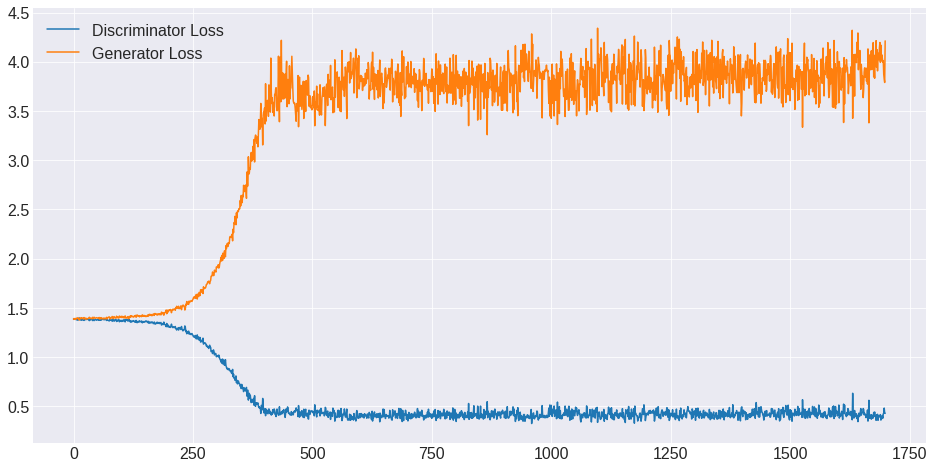

In [22]:
plt.figure(figsize = (16,8))
plt.plot(ld_list, label = "Discriminator Loss")
plt.plot(lg_list, label = "Generator Loss")
plt.legend()
pass

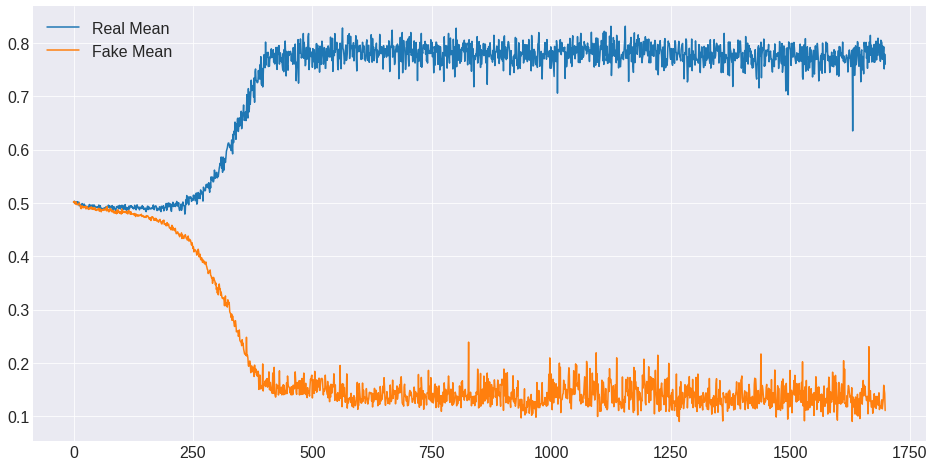

In [23]:
plt.figure(figsize = (16,8))
plt.plot(mr_list, label = "Real Mean")
plt.plot(mf_list, label = "Fake Mean")
plt.legend()
pass

In [24]:
sr = 22050
stft_mean = -39.25553443598964
stft_sd = 16.763774999817553

In [25]:
z_real.size()

torch.Size([35, 80])

In [26]:
fake = d_fake.cpu().data
real = d_real.cpu().data

In [27]:
fake.shape

torch.Size([35, 1, 32, 32])

In [28]:
plt.rcParams.update({'font.size': 16})

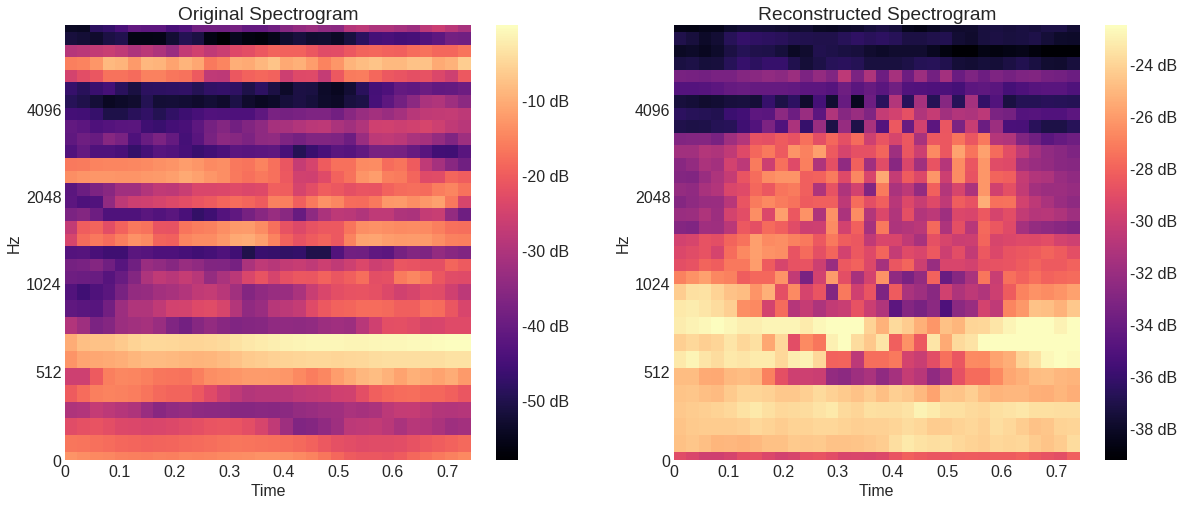

In [29]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(stft_sd*real[0,0, :, :].detach().numpy() + stft_mean, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Original Spectrogram")
plt.subplot(1,2,2)
librosa.display.specshow(stft_sd*fake[0,0, :, :].detach().numpy() + stft_mean,  x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Reconstructed Spectrogram")
pass

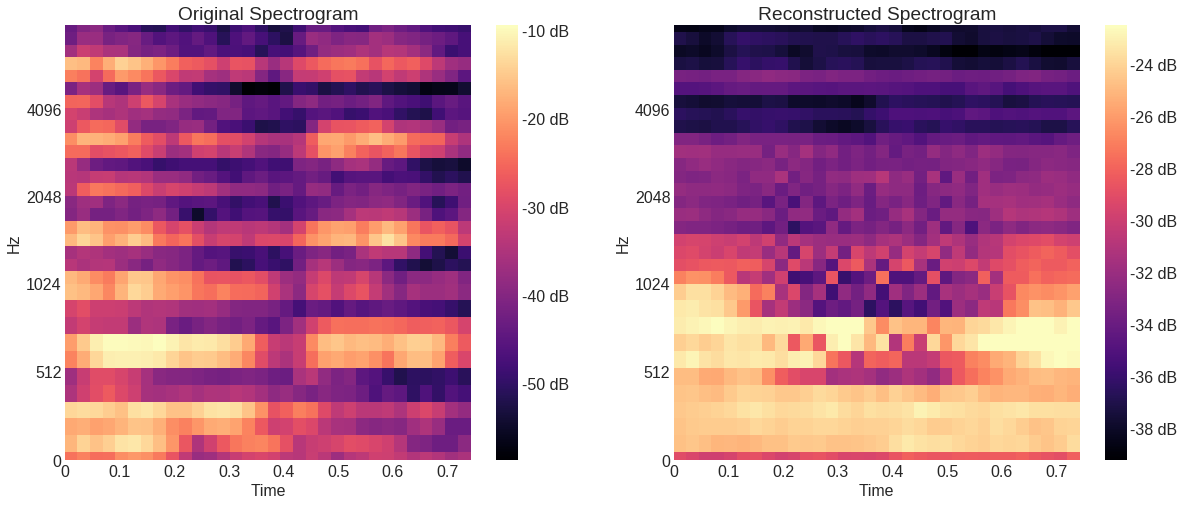

In [30]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(stft_sd*real[1,0, :, :].detach().numpy() + stft_mean, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Original Spectrogram")
plt.subplot(1,2,2)
librosa.display.specshow(stft_sd*fake[1,0, :, :].detach().numpy() + stft_mean,  x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Reconstructed Spectrogram")
pass

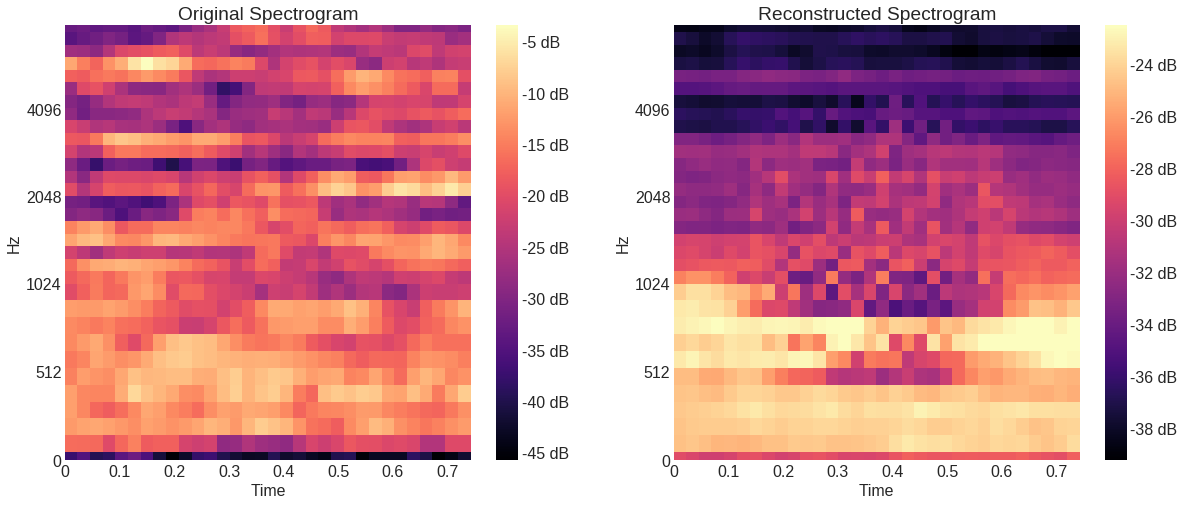

In [31]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(stft_sd*real[2,0, :, :].detach().numpy() + stft_mean, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Original Spectrogram")
plt.subplot(1,2,2)
librosa.display.specshow(stft_sd*fake[2,0, :, :].detach().numpy() + stft_mean,  x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Reconstructed Spectrogram")
pass

In [32]:
## Load data

train_stft1 = np.load("Data/train_stft-dB-3.npy", allow_pickle = True)
test_stft1 = np.load("Data/test_stft-dB-3.npy")
train_labels1 = np.load("Data/train_labels_stft-dB-3.npy")
test_labels1 = np.load("Data/test_labels_stft-dB-3.npy")

## Load new data
train_stft2 = np.load("Data/train_stft-dB-4.npy", allow_pickle = True)
test_stft2 = np.load("Data/test_stft-dB-4.npy")
train_labels2 = np.load("Data/train_labels_stft-dB-4.npy")
test_labels2 = np.load("Data/test_labels_stft-dB-4.npy")


train_stft = np.concatenate((train_stft1, train_stft2))
test_stft = np.concatenate((test_stft1, test_stft2))
train_labels = np.concatenate((train_labels1, train_labels2))
test_labels = np.concatenate((test_labels1, test_labels2))

In [33]:
# train_stft = np.concatenate((train_stft[:, :64,:64], train_stft[:, :64,64:2*64], train_stft[:, :64,2*64:3*64], 
#                              train_stft[:, :64,3*64:4*64], train_stft[:, :64,4*64:5*64],
#                              train_stft[:, :64,5*64:6*64]))
# train_labels = np.tile(train_labels, 6)

# test_stft = np.concatenate((test_stft[:, :64,:64], test_stft[:, :64,64:2*64], test_stft[:, :64,2*64:3*64], 
#                             test_stft[:, :64,3*64:4*64], test_stft[:, :64,4*64:5*64],
#                             test_stft[:, :64,5*64:6*64]))
# test_labels = np.tile(test_labels, 6)

In [34]:
train_stft = train_stft[:, :32, 32:64]
train_stft = np.resize(train_stft, (train_stft.shape[0],1,32,32))

In [35]:
batch_size = 16

train_set = MyDataset(train_stft, train_labels)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_set = MyDataset(test_stft, test_labels)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
# inputs, classes = next(iter(train_loader))  

In [36]:
for epoch in range(num_epochs):

    i = 0
    for (data, target) in train_loader:
        
        batch_size = data.size(0)
        
        real_label = Variable(torch.ones(batch_size).to(device))
        fake_label = Variable(torch.zeros(batch_size).to(device))

        noise1 = Variable(torch.Tensor(data.size()).normal_(0, 0.1 * (num_epochs - epoch) / num_epochs).to(device))
        noise2 = Variable(torch.Tensor(data.size()).normal_(0, 0.1 * (num_epochs - epoch) / num_epochs).to(device))

        if epoch == 0 and i == 0:
            netG.output_bias.data = get_log_odds(data.to(device))

        if data.size()[0] != batch_size:
            continue

        d_real = Variable(data.to(device))

        z_fake = Variable(torch.randn(batch_size, latent_size, 1, 1).to(device))
        d_fake = netG(z_fake)

        z_real, _, _, _ = netE(d_real)
        z_real = z_real.view(batch_size, -1)

        mu, log_sigma = z_real[:, :latent_size], z_real[:, latent_size:]
        sigma = torch.exp(log_sigma)
        epsilon = Variable(torch.randn(batch_size, latent_size).to(device))

        output_z = mu + epsilon * sigma

        output_real, _ = netD(d_real + noise1, output_z.view(batch_size, latent_size, 1, 1))
        output_fake, _ = netD(d_fake + noise2, z_fake)

        loss_d = criterion(output_real, real_label) + criterion(output_fake, fake_label)
        loss_g = criterion(output_fake, real_label) + criterion(output_real, fake_label)

        if loss_g.item() < 3.5:
            optimizerD.zero_grad()
            loss_d.backward(retain_graph=True)
            optimizerD.step()

        optimizerG.zero_grad()
        loss_g.backward()
        optimizerG.step()
        
        if i % 50 == 0:
            print("Epoch :", epoch, "Iteration:", i, "D Loss :", loss_d.item(), "G loss :", loss_g.item(),
                      "D(x) :", output_real.mean().item(), "D(G(x)) :", output_fake.mean().item())


#         if i % 50 == 0:
#             vutils.save_image(d_fake.cpu().data[:16, ], './%s/fake.png' % (opt.save_image_dir))
#             vutils.save_image(d_real.cpu().data[:16, ], './%s/real.png'% (opt.save_image_dir))

        i += 1
    
    print("Epoch :", epoch, "D Loss :", loss_d.item(), "G loss :", loss_g.item(),
                  "D(x) :", output_real.mean().item(), "D(G(x)) :", output_fake.mean().item())


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch : 0 Iteration: 0 D Loss : 0.4129487872123718 G loss : 4.037831783294678 D(x) : 0.7393947839736938 D(G(x)) : 0.09074725210666656
Epoch : 0 Iteration: 50 D Loss : 0.3348519206047058 G loss : 4.657383918762207 D(x) : 0.797416090965271 D(G(x)) : 0.07477310299873352
Epoch : 0 Iteration: 100 D Loss : 0.35148870944976807 G loss : 4.6541547775268555 D(x) : 0.8149986267089844 D(G(x)) : 0.11291567981243134
Epoch : 0 D Loss : 0.3474181592464447 G loss : 5.478799819946289 D(x) : 0.8565240502357483 D(G(x)) : 0.16029885411262512
Epoch : 1 Iteration: 0 D Loss : 0.2838837504386902 G loss : 4.765685081481934 D(x) : 0.863101601600647 D(G(x)) : 0.11773167550563812
Epoch : 1 Iteration: 50 D Loss : 0.34217506647109985 G loss : 4.303891181945801 D(x) : 0.8671485185623169 D(G(x)) : 0.1673746407032013
Epoch : 1 Iteration: 100 D Loss : 0.3504989743232727 G loss : 4.258002281188965 D(x) : 0.8364916443824768 D(G(x)) : 0.1419987827539444
Epoch : 1 D Loss : 0.38591593503952026 G loss : 4.587505340576172 D(x)

In [37]:
fake = d_fake.cpu().data
real = d_real.cpu().data

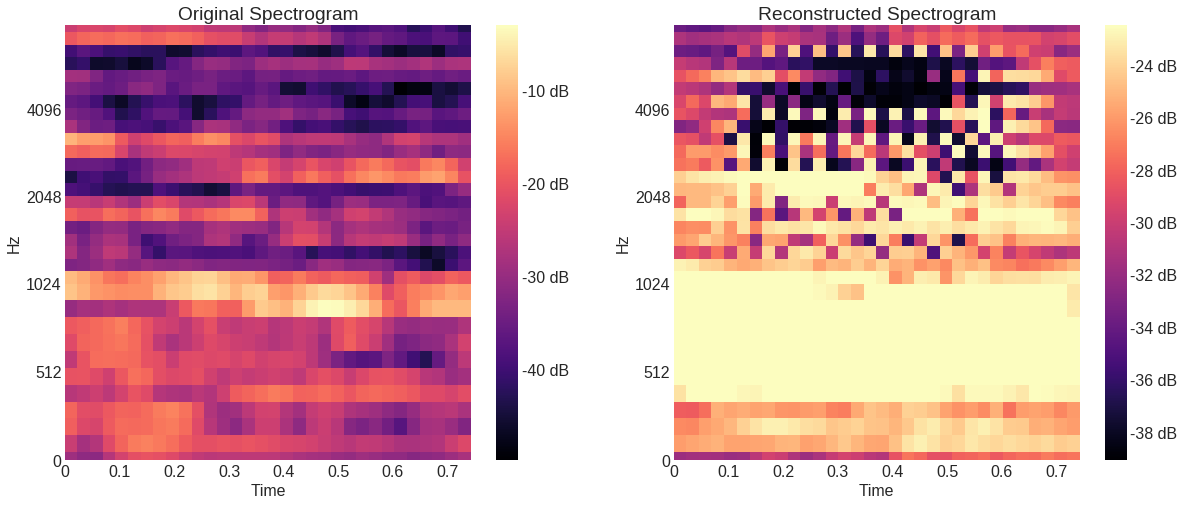

In [38]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(stft_sd*real[0,0, :, :].detach().numpy() + stft_mean, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Original Spectrogram")
plt.subplot(1,2,2)
librosa.display.specshow(stft_sd*fake[0,0, :, :].detach().numpy() + stft_mean,  x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Reconstructed Spectrogram")
pass

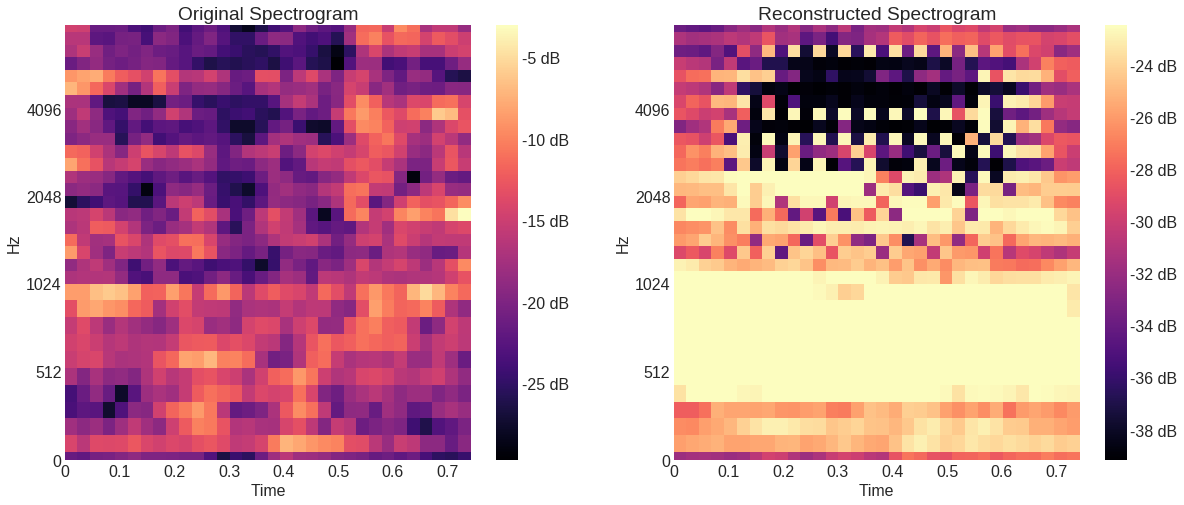

In [39]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(stft_sd*real[1,0, :, :].detach().numpy() + stft_mean, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Original Spectrogram")
plt.subplot(1,2,2)
librosa.display.specshow(stft_sd*fake[1,0, :, :].detach().numpy() + stft_mean,  x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Reconstructed Spectrogram")
pass

In [40]:
# plt.figure(figsize = (20,8))
# plt.subplot(1, 2, 1)
# librosa.display.specshow(stft_sd*real[2,0, :, :].detach().numpy() + stft_mean, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
# plt.colorbar(format='%+2.0f dB')
# plt.title("Original Spectrogram")
# plt.subplot(1,2,2)
# librosa.display.specshow(stft_sd*fake[2,0, :, :].detach().numpy() + stft_mean,  x_axis='time',y_axis='mel', sr=sr,fmax=8000)
# plt.colorbar(format='%+2.0f dB')
# plt.title("Reconstructed Spectrogram")
# pass

Last chunk of data

In [41]:
## Load data

train_stft = np.load("Data/train_stft-dB-5.npy", allow_pickle = True)
test_stft = np.load("Data/test_stft-dB-5.npy")
train_labels = np.load("Data/train_labels_stft-dB-5.npy")
test_labels = np.load("Data/test_labels_stft-dB-5.npy")


# train_stft = np.concatenate((train_stft[:, :64,:64], train_stft[:, :64,64:2*64], train_stft[:, :64,2*64:3*64], 
#                              train_stft[:, :64,3*64:4*64], train_stft[:, :64,4*64:5*64],
#                              train_stft[:, :64,5*64:6*64]))
# train_labels = np.tile(train_labels, 6)

# test_stft = np.concatenate((test_stft[:, :64,:64], test_stft[:, :64,64:2*64], test_stft[:, :64,2*64:3*64], 
#                             test_stft[:, :64,3*64:4*64], test_stft[:, :64,4*64:5*64],
#                             test_stft[:, :64,5*64:6*64]))
# test_labels = np.tile(test_labels, 6)

train_stft = train_stft[:, :32, 32:64]
train_stft = np.resize(train_stft, (train_stft.shape[0],1,32,32))

test_stft = test_stft[:, :32, 32:64]
test_stft = np.resize(test_stft, (test_stft.shape[0],1,32,32))

In [42]:
train_stft.shape

(1073, 1, 32, 32)

In [43]:
batch_size = 32

train_set = MyDataset(train_stft, train_labels)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_set = MyDataset(test_stft, test_labels)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
# inputs, classes = next(iter(train_loader))  

In [44]:
for epoch in range(num_epochs):

    i = 0
    for (data, target) in train_loader:
        
        batch_size = data.size(0)
        
        real_label = Variable(torch.ones(batch_size).to(device))
        fake_label = Variable(torch.zeros(batch_size).to(device))

        noise1 = Variable(torch.Tensor(data.size()).normal_(0, 0.1 * (num_epochs - epoch) / num_epochs).to(device))
        noise2 = Variable(torch.Tensor(data.size()).normal_(0, 0.1 * (num_epochs - epoch) / num_epochs).to(device))

        if epoch == 0 and i == 0:
            netG.output_bias.data = get_log_odds(data.to(device))

        if data.size()[0] != batch_size:
            continue

        d_real = Variable(data.to(device))

        z_fake = Variable(torch.randn(batch_size, latent_size, 1, 1).to(device))
        d_fake = netG(z_fake)

        z_real, _, _, _ = netE(d_real)
        z_real = z_real.view(batch_size, -1)

        mu, log_sigma = z_real[:, :latent_size], z_real[:, latent_size:]
        sigma = torch.exp(log_sigma)
        epsilon = Variable(torch.randn(batch_size, latent_size).to(device))

        output_z = mu + epsilon * sigma

        output_real, _ = netD(d_real + noise1, output_z.view(batch_size, latent_size, 1, 1))
        output_fake, _ = netD(d_fake + noise2, z_fake)

        loss_d = criterion(output_real, real_label) + criterion(output_fake, fake_label)
        loss_g = criterion(output_fake, real_label) + criterion(output_real, fake_label)

        if loss_g.item() < 3.5:
            optimizerD.zero_grad()
            loss_d.backward(retain_graph=True)
            optimizerD.step()

        optimizerG.zero_grad()
        loss_g.backward()
        optimizerG.step()
        
        if i % 50 == 0:
            print("Epoch :", epoch, "Iteration:", i, "D Loss :", loss_d.item(), "G loss :", loss_g.item(),
                      "D(x) :", output_real.mean().item(), "D(G(x)) :", output_fake.mean().item())


#         if i % 50 == 0:
#             vutils.save_image(d_fake.cpu().data[:16, ], './%s/fake.png' % (opt.save_image_dir))
#             vutils.save_image(d_real.cpu().data[:16, ], './%s/real.png'% (opt.save_image_dir))

        i += 1
    
    print("Epoch :", epoch, "D Loss :", loss_d.item(), "G loss :", loss_g.item(),
                  "D(x) :", output_real.mean().item(), "D(G(x)) :", output_fake.mean().item())


Epoch : 0 Iteration: 0 D Loss : 0.25235098600387573 G loss : 4.838793754577637 D(x) : 0.9068338871002197 D(G(x)) : 0.13350418210029602
Epoch : 0 D Loss : 0.5004453063011169 G loss : 4.023908615112305 D(x) : 0.877163827419281 D(G(x)) : 0.28703850507736206
Epoch : 1 Iteration: 0 D Loss : 0.3209834098815918 G loss : 4.368405342102051 D(x) : 0.8927732706069946 D(G(x)) : 0.17497733235359192
Epoch : 1 D Loss : 0.3656547963619232 G loss : 4.230973243713379 D(x) : 0.895457923412323 D(G(x)) : 0.20487210154533386
Epoch : 2 Iteration: 0 D Loss : 0.5343314409255981 G loss : 3.6243605613708496 D(x) : 0.8745771050453186 D(G(x)) : 0.30535367131233215
Epoch : 2 D Loss : 0.356082022190094 G loss : 4.369983196258545 D(x) : 0.9121246337890625 D(G(x)) : 0.22060276567935944
Epoch : 3 Iteration: 0 D Loss : 0.6169329285621643 G loss : 3.2333948612213135 D(x) : 0.8205088973045349 D(G(x)) : 0.3139454126358032
Epoch : 3 D Loss : 0.545023500919342 G loss : 3.512824773788452 D(x) : 0.8871508240699768 D(G(x)) : 0.

In [45]:
fake = d_fake.cpu().data
real = d_real.cpu().data

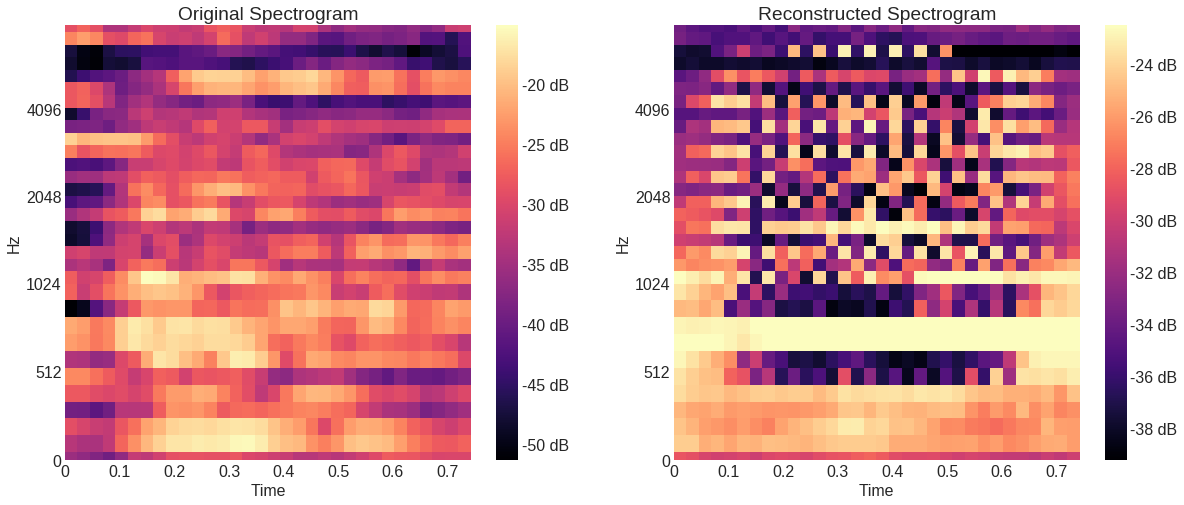

In [46]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(stft_sd*real[0,0, :, :].detach().numpy() + stft_mean, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Original Spectrogram")
plt.subplot(1,2,2)
librosa.display.specshow(stft_sd*fake[0,0, :, :].detach().numpy() + stft_mean,  x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Reconstructed Spectrogram")
pass

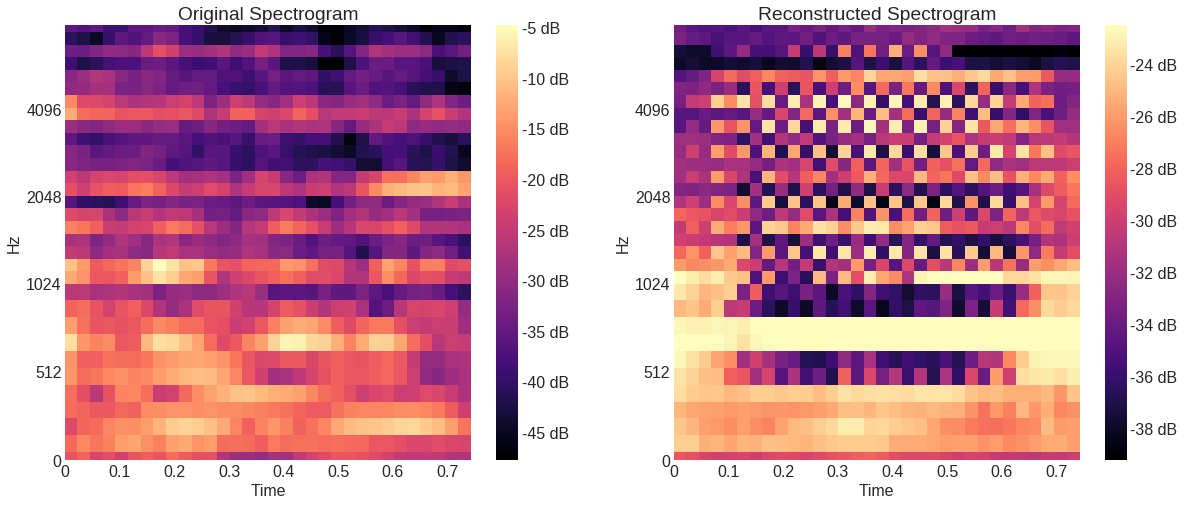

In [47]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(stft_sd*real[1,0, :, :].detach().numpy() + stft_mean, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Original Spectrogram")
plt.subplot(1,2,2)
librosa.display.specshow(stft_sd*fake[1,0, :, :].detach().numpy() + stft_mean,  x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Reconstructed Spectrogram")
pass

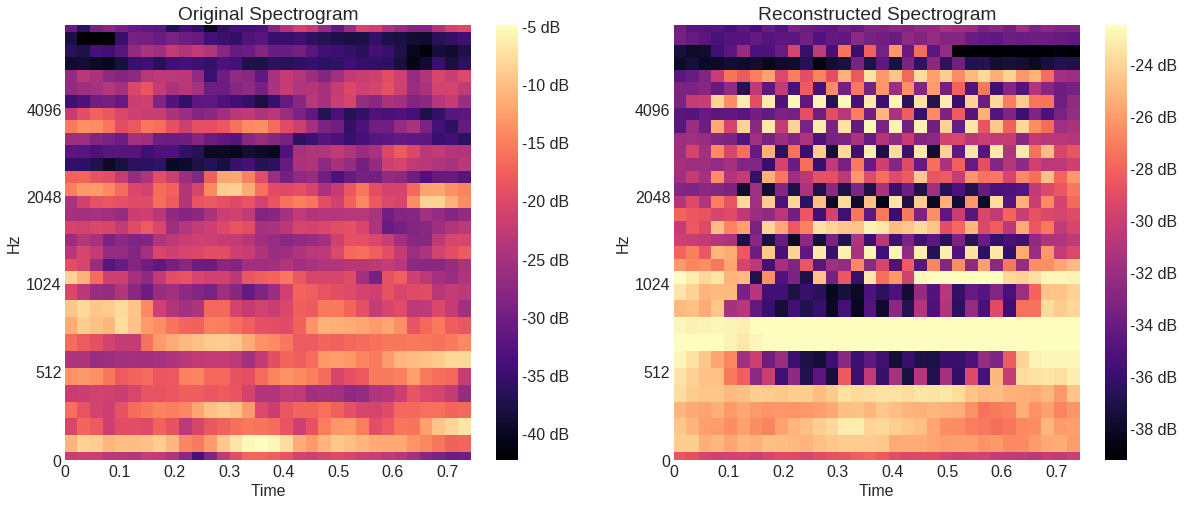

In [48]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(stft_sd*real[12,0, :, :].detach().numpy() + stft_mean, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Original Spectrogram")
plt.subplot(1,2,2)
librosa.display.specshow(stft_sd*fake[12,0, :, :].detach().numpy() + stft_mean,  x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Reconstructed Spectrogram")
pass

In [50]:
torch.save(netG.state_dict(), 'ALI_generator-40.pth')
torch.save(netE.state_dict(), 'ALI_encoder-40.pth' )
torch.save(netD.state_dict(), 'ALI_decoder-40.pth' )

## Classify

In [51]:
ALI_train_features = torch.zeros(1, latent_size*2)
for batch_idx, (data, target) in enumerate(train_loader):
    
    data = data.to(device)
    z_real, _, _, _ = netE(data)
    ALI_train_features = torch.cat((ALI_train_features, z_real[:,:,0,0].cpu()), 0)
    
    if batch_idx == 0:
        ALI_train_labels = target
    else:
        ALI_train_labels = torch.cat((ALI_train_labels, target), 0)

In [52]:
ALI_train_features = ALI_train_features[1:, :]
ALI_train_features.shape

torch.Size([1073, 80])

In [53]:
ALI_test_features = torch.zeros(1, latent_size*2)
for batch_idx, (data, target) in enumerate(test_loader):
    
    data = data.to(device)
    z_real, _, _, _ = netE(data)
    ALI_test_features = torch.cat((ALI_test_features, z_real[:,:,0,0].cpu()), 0)
    
    if batch_idx == 0:
        ALI_test_labels = target
    else:
        ALI_test_labels = torch.cat((ALI_test_labels, target), 0)

In [54]:
ALI_test_features = ALI_test_features[1:, :]
ALI_test_features.shape

torch.Size([768, 80])

In [55]:
ALI_train_features1 = ALI_train_features.detach().numpy()
ALI_test_features1 = ALI_test_features.detach().numpy()
ALI_train_labels1 = ALI_train_labels.numpy()
ALI_test_labels1 = ALI_test_labels.numpy()

In [56]:
## Load data

train_stft1 = np.load("Data/train_stft-dB-1.npy", allow_pickle = True)
test_stft1 = np.load("Data/test_stft-dB-1.npy")
train_labels1 = np.load("Data/train_labels_stft-dB-1.npy")
test_labels1 = np.load("Data/test_labels_stft-dB-1.npy")

## Load new data
train_stft2 = np.load("Data/train_stft-dB-2.npy", allow_pickle = True)
test_stft2 = np.load("Data/test_stft-dB-2.npy")
train_labels2 = np.load("Data/train_labels_stft-dB-2.npy")
test_labels2 = np.load("Data/test_labels_stft-dB-2.npy")


train_stft = np.concatenate((train_stft1, train_stft2))
test_stft = np.concatenate((test_stft1, test_stft2))
train_labels = np.concatenate((train_labels1, train_labels2))
test_labels = np.concatenate((test_labels1, test_labels2))

train_stft = train_stft[:, :32, 32:64]
train_stft = np.resize(train_stft, (train_stft.shape[0],1,32,32))

test_stft = test_stft[:, :32, 32:64]
test_stft = np.resize(test_stft, (test_stft.shape[0],1,32,32))

In [57]:
batch_size = 16

train_set = MyDataset(train_stft, train_labels)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_set = MyDataset(test_stft, test_labels)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [58]:
ALI_train_features = torch.zeros(1, latent_size*2)
for batch_idx, (data, target) in enumerate(train_loader):
    
    data = data.to(device)
    z_real, _, _, _ = netE(data)
    ALI_train_features = torch.cat((ALI_train_features, z_real[:,:,0,0].cpu()), 0)
    
    if batch_idx == 0:
        ALI_train_labels = target
    else:
        ALI_train_labels = torch.cat((ALI_train_labels, target), 0)

In [59]:
ALI_train_features = ALI_train_features[1:, :]
ALI_train_features.shape

torch.Size([2147, 80])

In [60]:
ALI_test_features = torch.zeros(1, latent_size*2)
for batch_idx, (data, target) in enumerate(test_loader):
    
    data = data.to(device)
    z_real, _, _, _ = netE(data)
    ALI_test_features = torch.cat((ALI_test_features, z_real[:,:,0,0].cpu()), 0)
    
    if batch_idx == 0:
        ALI_test_labels = target
    else:
        ALI_test_labels = torch.cat((ALI_test_labels, target), 0)

In [61]:
ALI_test_features = ALI_test_features[1:, :]
ALI_test_features.shape

torch.Size([1538, 80])

In [62]:
ALI_train_features2 = ALI_train_features.detach().numpy()
ALI_test_features2 = ALI_test_features.detach().numpy()
ALI_train_labels2 = ALI_train_labels.numpy()
ALI_test_labels2 = ALI_test_labels.numpy()

In [63]:
## Load data

train_stft1 = np.load("Data/train_stft-dB-3.npy", allow_pickle = True)
test_stft1 = np.load("Data/test_stft-dB-3.npy")
train_labels1 = np.load("Data/train_labels_stft-dB-3.npy")
test_labels1 = np.load("Data/test_labels_stft-dB-3.npy")

## Load new data
train_stft2 = np.load("Data/train_stft-dB-4.npy", allow_pickle = True)
test_stft2 = np.load("Data/test_stft-dB-4.npy")
train_labels2 = np.load("Data/train_labels_stft-dB-4.npy")
test_labels2 = np.load("Data/test_labels_stft-dB-4.npy")


train_stft = np.concatenate((train_stft1, train_stft2))
test_stft = np.concatenate((test_stft1, test_stft2))
train_labels = np.concatenate((train_labels1, train_labels2))
test_labels = np.concatenate((test_labels1, test_labels2))

train_stft = train_stft[:, :32, 32:64]
train_stft = np.resize(train_stft, (train_stft.shape[0],1,32,32))

test_stft = test_stft[:, :32, 32:64]
test_stft = np.resize(test_stft, (test_stft.shape[0],1,32,32))

In [64]:
batch_size = 16

train_set = MyDataset(train_stft, train_labels)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_set = MyDataset(test_stft, test_labels)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [65]:
ALI_train_features = torch.zeros(1, latent_size*2)
for batch_idx, (data, target) in enumerate(train_loader):
    
    data = data.to(device)
    z_real, _, _, _ = netE(data)
    ALI_train_features = torch.cat((ALI_train_features, z_real[:,:,0,0].cpu()), 0)
    
    if batch_idx == 0:
        ALI_train_labels = target
    else:
        ALI_train_labels = torch.cat((ALI_train_labels, target), 0)

In [66]:
ALI_train_features = ALI_train_features[1:, :]
ALI_train_features.shape

torch.Size([2146, 80])

In [67]:
ALI_train_labels.shape

torch.Size([2146])

In [68]:
ALI_test_features = torch.zeros(1, latent_size*2)
for batch_idx, (data, target) in enumerate(test_loader):
    
    data = data.to(device)
    z_real, _, _, _ = netE(data)
    ALI_test_features = torch.cat((ALI_test_features, z_real[:,:,0,0].cpu()), 0)
    
    if batch_idx == 0:
        ALI_test_labels = target
    else:
        ALI_test_labels = torch.cat((ALI_test_labels, target), 0)

In [69]:
ALI_test_features = ALI_test_features[1:, :]
ALI_test_features.shape

torch.Size([1536, 80])

In [70]:
ALI_test_labels.shape

torch.Size([1536])

In [71]:
ALI_train_features3 = ALI_train_features.detach().numpy()
ALI_test_features3 = ALI_test_features.detach().numpy()
ALI_train_labels3 = ALI_train_labels.numpy()
ALI_test_labels3 = ALI_test_labels.numpy()

In [72]:
ALI_train_features = np.concatenate((ALI_train_features1, ALI_train_features2, ALI_train_features3))
ALI_test_features = np.concatenate((ALI_test_features1, ALI_test_features2, ALI_test_features3))
ALI_train_labels = np.concatenate((ALI_train_labels1, ALI_train_labels2, ALI_train_labels3))
ALI_test_labels = np.concatenate((ALI_test_labels1, ALI_test_labels2, ALI_test_labels3))

In [73]:
## Classify via logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [74]:
ALI_train_features = ALI_train_features2
ALI_test_features = ALI_test_features2
ALI_train_labels = ALI_train_labels2
ALI_test_labels = ALI_test_labels2

In [75]:
clf = LogisticRegression(multi_class='multinomial', solver='saga',
                        max_iter = 10000).fit(X=ALI_train_features, y=ALI_train_labels)

In [76]:
## Training Accuracy
y_pred = clf.predict(ALI_train_features)
ALI_train_acc = metrics.accuracy_score(ALI_train_labels, y_pred)
ALI_train_acc

0.33209129017233346

In [77]:
## Test Accuracy
y_pred = clf.predict(ALI_test_features)
ALI_test_acc = metrics.accuracy_score(ALI_test_labels, y_pred)
ALI_test_acc

0.2867360208062419

## UMAP

In [82]:
import umap.umap_ as umap

In [81]:
# ! pip install umap-learn

In [83]:
import warnings
warnings.filterwarnings('ignore')

In [84]:
reducer = umap.UMAP(n_neighbors=75, min_dist = 0.5, metric = "cosine")
embedding = reducer.fit_transform(ALI_train_features)
embedding.shape

(2147, 2)

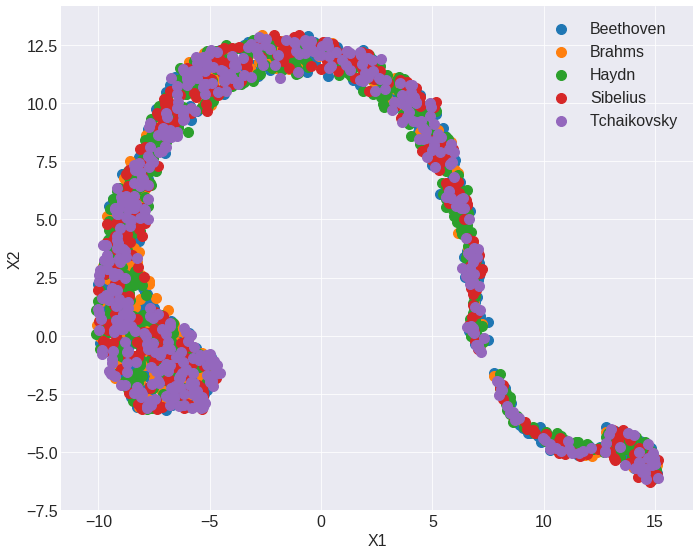

In [85]:
cdict = {0: 'C0', 1: 'C1', 2: 'C2', 3: 'C3', 4: 'C4'}
composers = ["Beethoven", "Brahms", "Haydn", "Sibelius", "Tchaikovsky"]
fig, ax = plt.subplots(figsize = (10,8))
for g in np.unique(ALI_train_labels):
    ix = np.where(ALI_train_labels == g)
    ax.scatter(embedding[ix, 0], embedding[ix, 1], c = cdict[g], label = composers[g], s = 100)
ax.legend()
plt.xlabel("X1")
plt.ylabel("X2")
plt.tight_layout()
# plt.savefig('ALI-UMAP-spec32x32-train.png')
plt.show()

In [86]:
reducer = umap.UMAP(n_neighbors=75, min_dist = 0.5, metric = "cosine")
embedding = reducer.fit_transform(ALI_test_features)
embedding.shape

(1538, 2)

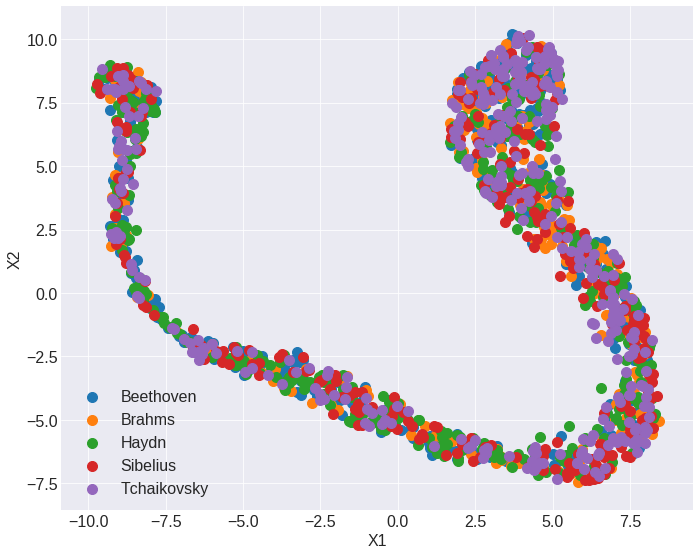

In [87]:
cdict = {0: 'C0', 1: 'C1', 2: 'C2', 3: 'C3', 4: 'C4'}
composers = ["Beethoven", "Brahms", "Haydn", "Sibelius", "Tchaikovsky"]
fig, ax = plt.subplots(figsize = (10,8))
for g in np.unique(ALI_test_labels):
    ix = np.where(ALI_test_labels == g)
    ax.scatter(embedding[ix, 0], embedding[ix, 1], c = cdict[g], label = composers[g], s = 100)
ax.legend()
plt.xlabel("X1")
plt.ylabel("X2")
plt.tight_layout()
plt.savefig('ALI-UMAP-spec32x32-test.png')
plt.show()

## Interpolate in Latent Space

In [116]:
z_interp = np.resize(np.array(np.split(np.tile(np.linspace(start=0, stop=1, num=16), (40,1)), 
                                       16, axis = 1)), (16,40,1,1))

In [117]:
z_interp.shape

(16, 40, 1, 1)

In [123]:
z_fake = Variable(torch.tensor(z_interp)).float().to(device)

In [124]:
gen_interp = netG(z_fake)

In [125]:
gen_interp.shape

torch.Size([16, 1, 32, 32])

In [127]:
gen_interp = gen_interp.cpu().data

In [130]:
np.linspace(start=0, stop=1, num=16)

array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
       0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
       0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
       1.        ])

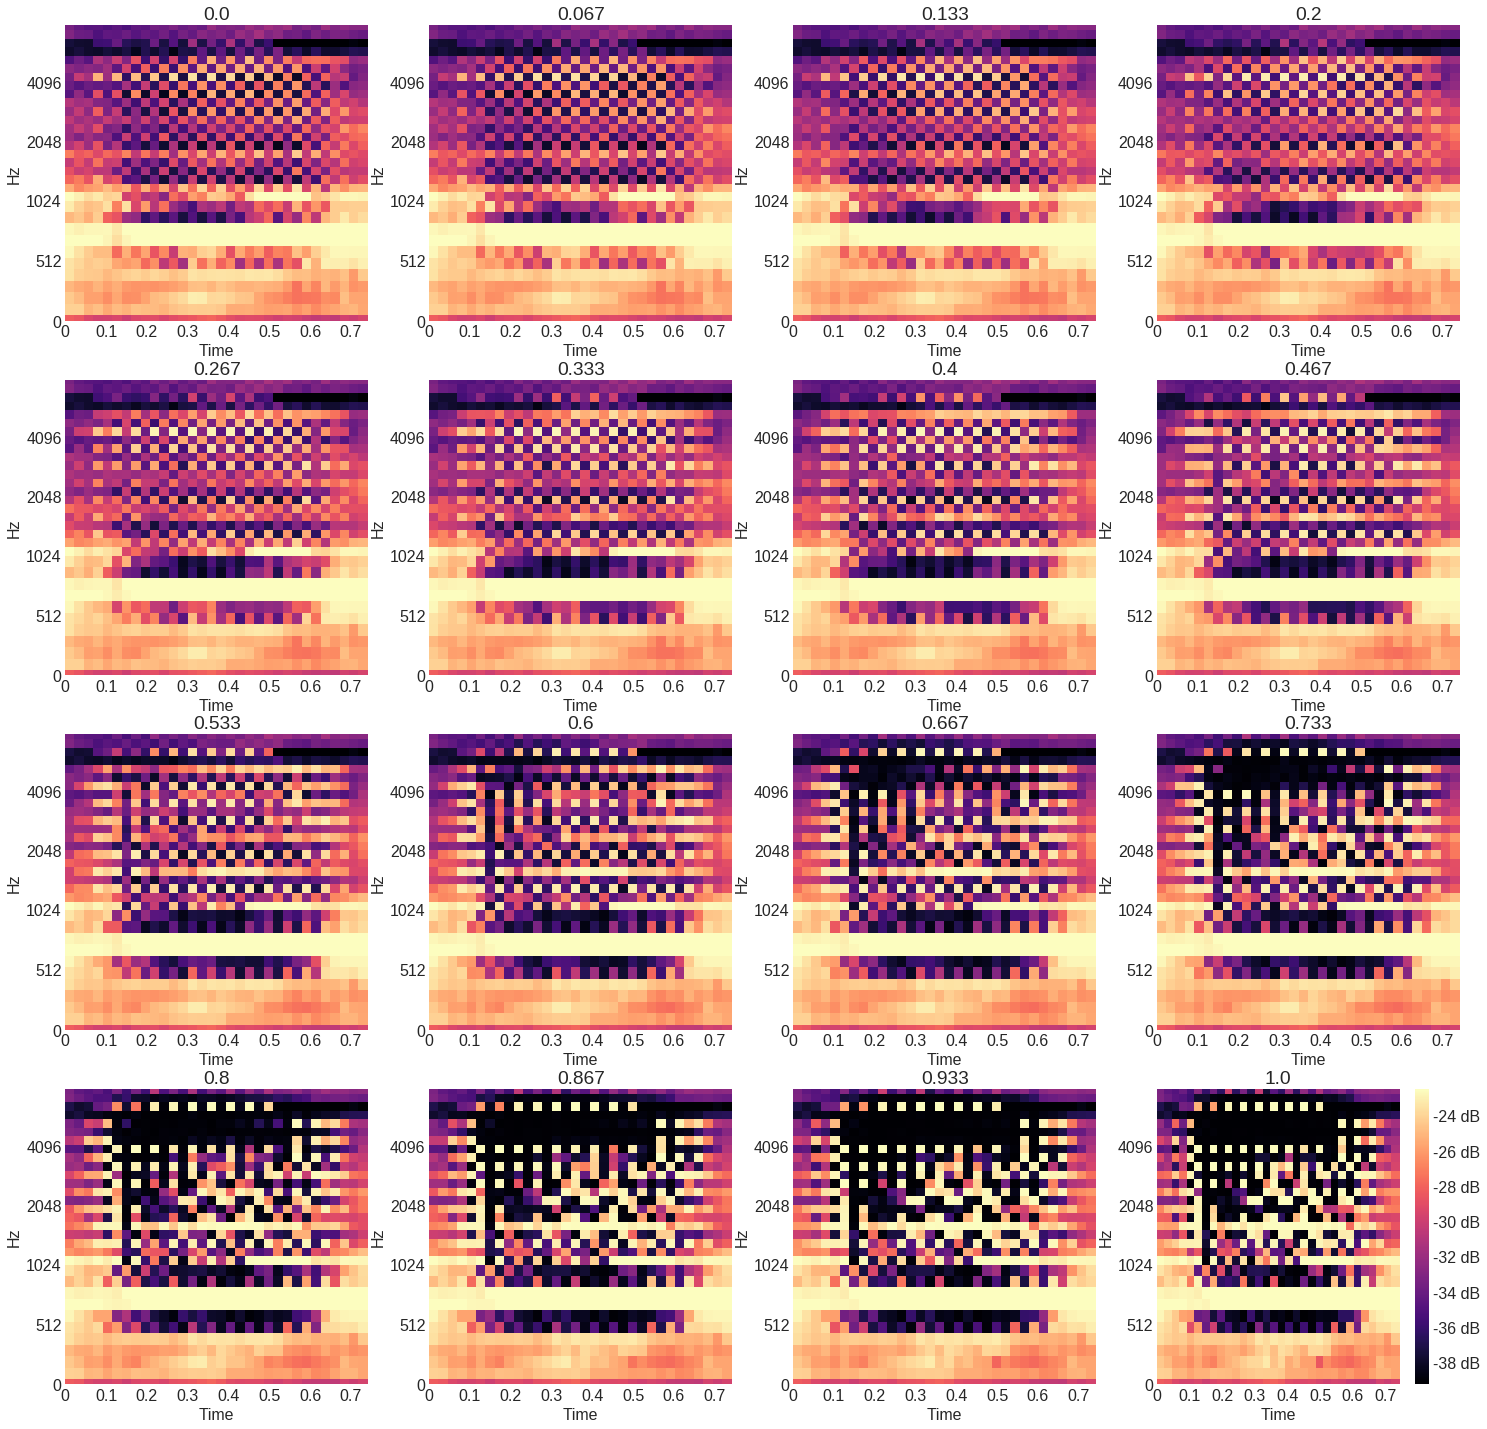

In [141]:
plt.figure(figsize = (25,25))
plt.subplot(4, 4, 1)
librosa.display.specshow(stft_sd*gen_interp[0,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.0")
plt.subplot(4,4,2)
librosa.display.specshow(stft_sd*gen_interp[1,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.067")
plt.subplot(4, 4, 3)
librosa.display.specshow(stft_sd*gen_interp[2,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.133")
plt.subplot(4,4,4)
librosa.display.specshow(stft_sd*gen_interp[3,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
# plt.colorbar(format='%+2.0f dB')
plt.title("0.2")
###########
plt.subplot(4, 4, 5)
librosa.display.specshow(stft_sd*gen_interp[4,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.267")
plt.subplot(4,4,6)
librosa.display.specshow(stft_sd*gen_interp[5,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.333")
plt.subplot(4, 4, 7)
librosa.display.specshow(stft_sd*gen_interp[6,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.4")
plt.subplot(4,4,8)
librosa.display.specshow(stft_sd*gen_interp[7,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
# plt.colorbar(format='%+2.0f dB')
plt.title("0.467")

###########
plt.subplot(4, 4, 9)
librosa.display.specshow(stft_sd*gen_interp[8,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.533")
plt.subplot(4,4,10)
librosa.display.specshow(stft_sd*gen_interp[9,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.6")
plt.subplot(4, 4, 11)
librosa.display.specshow(stft_sd*gen_interp[10,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.667")
plt.subplot(4,4,12)
librosa.display.specshow(stft_sd*gen_interp[11,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
# plt.colorbar(format='%+2.0f dB')
plt.title("0.733")

###########
plt.subplot(4, 4, 13)
librosa.display.specshow(stft_sd*gen_interp[12,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.8")
plt.subplot(4,4,14)
librosa.display.specshow(stft_sd*gen_interp[13,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.867")
plt.subplot(4, 4, 15)
librosa.display.specshow(stft_sd*gen_interp[14,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.933")
plt.subplot(4,4,16)
librosa.display.specshow(stft_sd*gen_interp[15,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("1.0")


pass

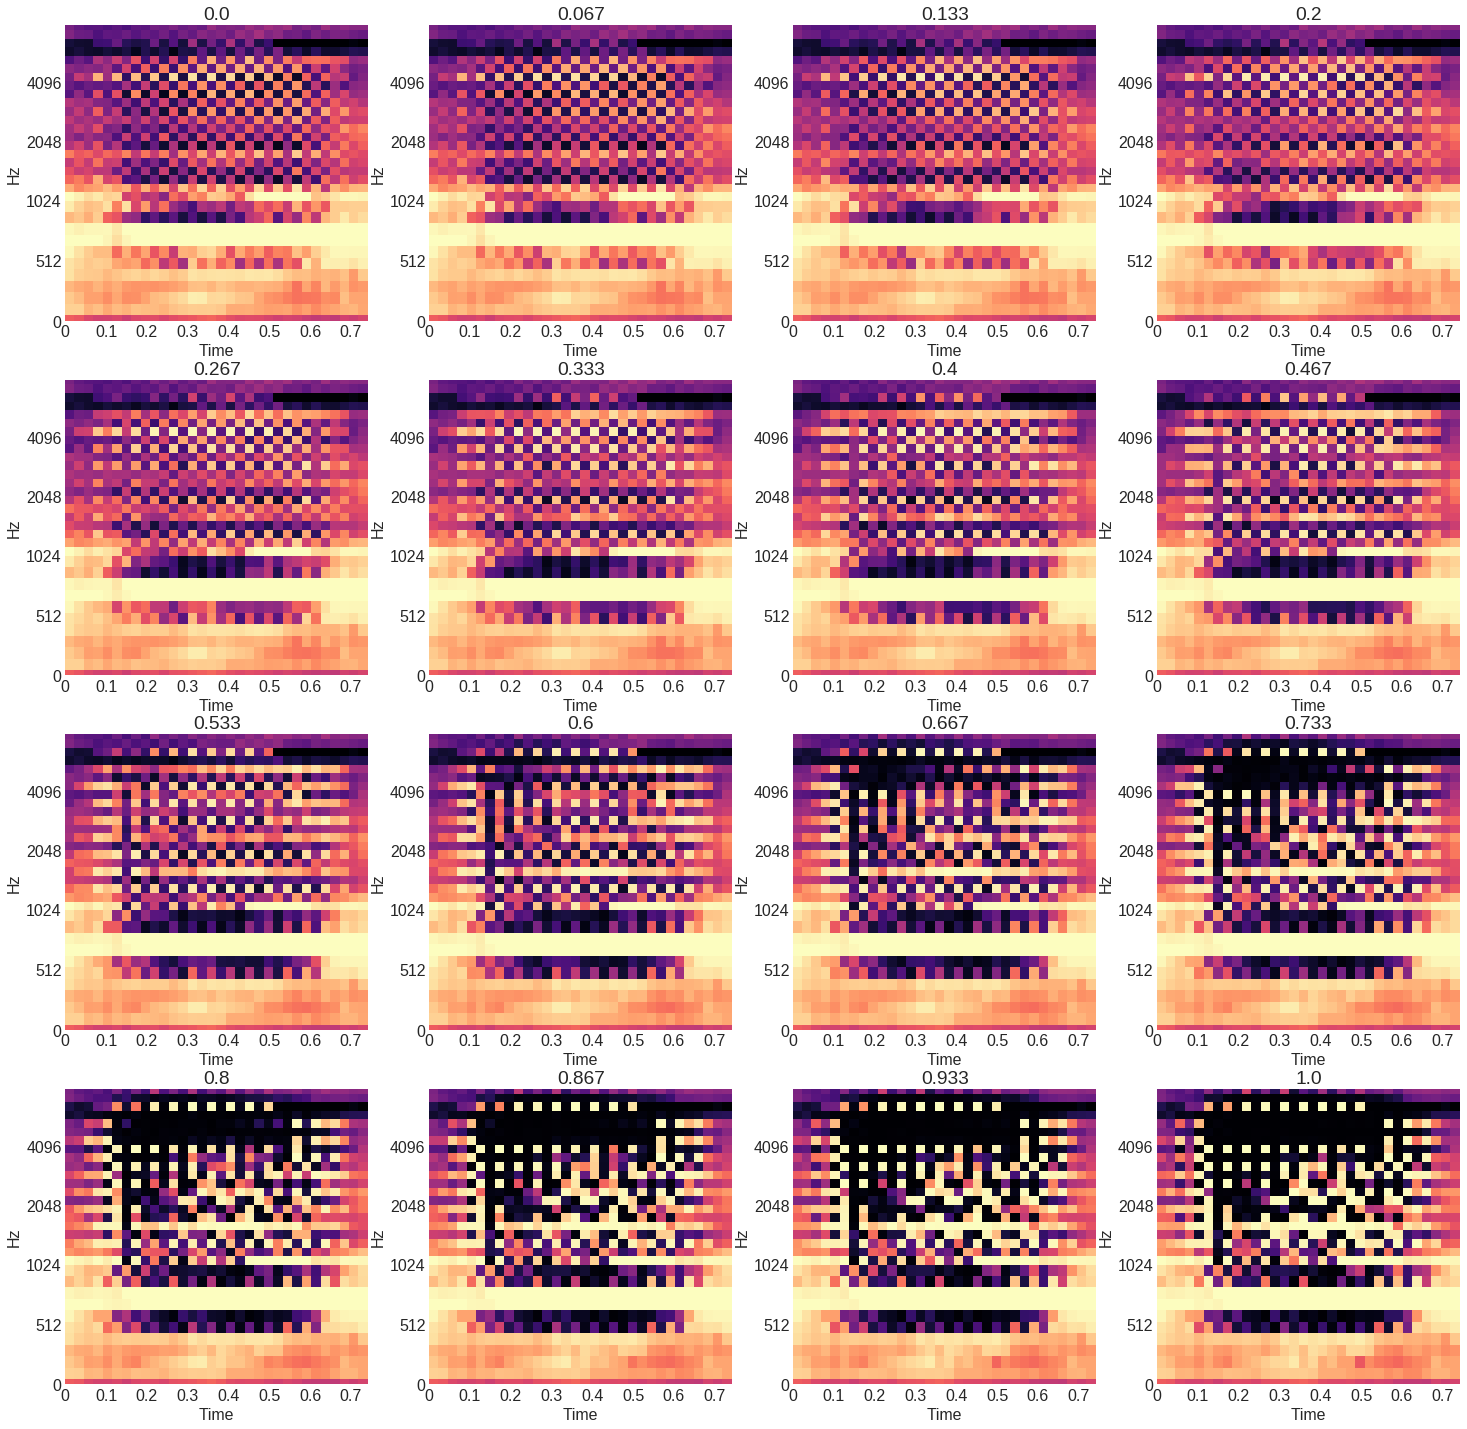

In [142]:
plt.figure(figsize = (25,25))
plt.subplot(4, 4, 1)
librosa.display.specshow(stft_sd*gen_interp[0,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.0")
plt.subplot(4,4,2)
librosa.display.specshow(stft_sd*gen_interp[1,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.067")
plt.subplot(4, 4, 3)
librosa.display.specshow(stft_sd*gen_interp[2,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.133")
plt.subplot(4,4,4)
librosa.display.specshow(stft_sd*gen_interp[3,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
# plt.colorbar(format='%+2.0f dB')
plt.title("0.2")
###########
plt.subplot(4, 4, 5)
librosa.display.specshow(stft_sd*gen_interp[4,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.267")
plt.subplot(4,4,6)
librosa.display.specshow(stft_sd*gen_interp[5,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.333")
plt.subplot(4, 4, 7)
librosa.display.specshow(stft_sd*gen_interp[6,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.4")
plt.subplot(4,4,8)
librosa.display.specshow(stft_sd*gen_interp[7,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
# plt.colorbar(format='%+2.0f dB')
plt.title("0.467")

###########
plt.subplot(4, 4, 9)
librosa.display.specshow(stft_sd*gen_interp[8,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.533")
plt.subplot(4,4,10)
librosa.display.specshow(stft_sd*gen_interp[9,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.6")
plt.subplot(4, 4, 11)
librosa.display.specshow(stft_sd*gen_interp[10,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.667")
plt.subplot(4,4,12)
librosa.display.specshow(stft_sd*gen_interp[11,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
# plt.colorbar(format='%+2.0f dB')
plt.title("0.733")

###########
plt.subplot(4, 4, 13)
librosa.display.specshow(stft_sd*gen_interp[12,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.8")
plt.subplot(4,4,14)
librosa.display.specshow(stft_sd*gen_interp[13,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.867")
plt.subplot(4, 4, 15)
librosa.display.specshow(stft_sd*gen_interp[14,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.933")
plt.subplot(4,4,16)
librosa.display.specshow(stft_sd*gen_interp[15,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("1.0")


pass

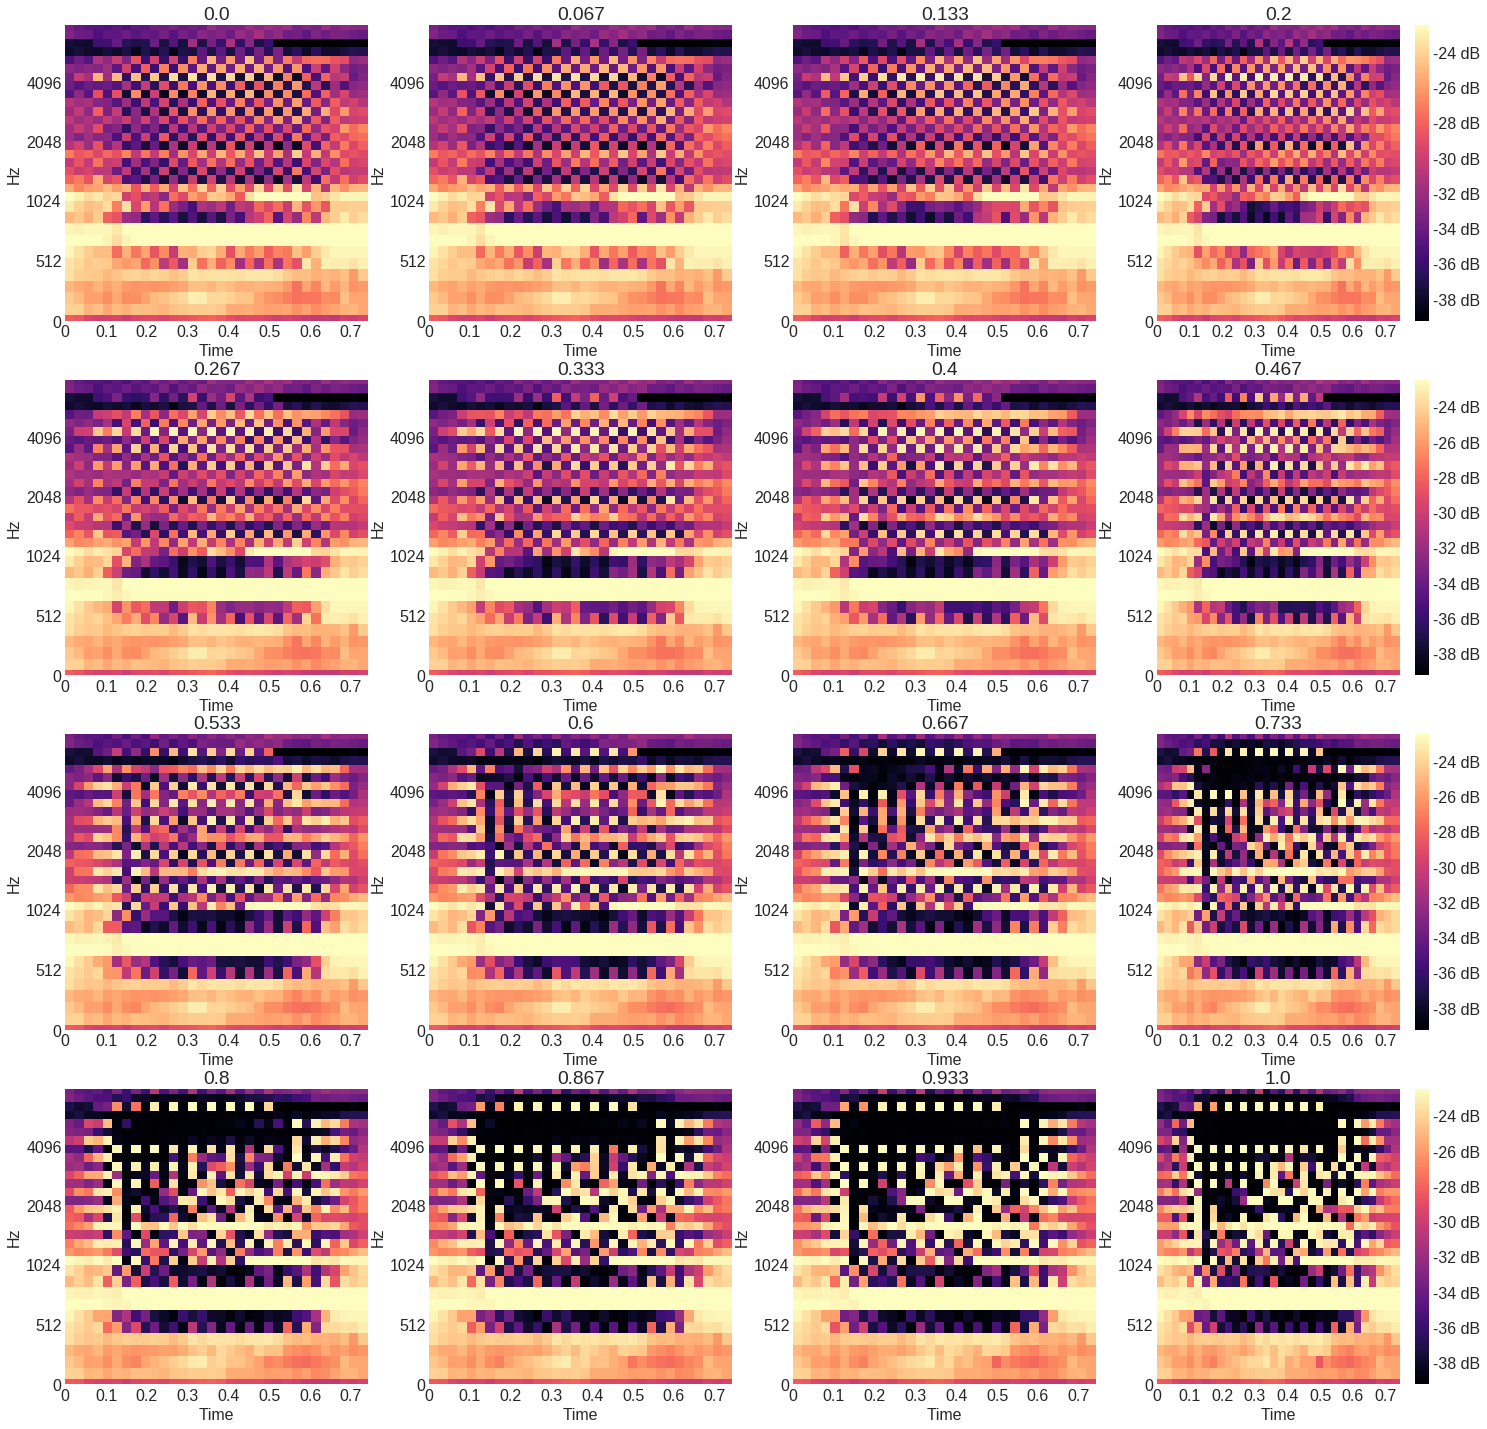

In [144]:
plt.figure(figsize = (25,25))
plt.subplot(4, 4, 1)
librosa.display.specshow(stft_sd*gen_interp[0,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.0")
plt.subplot(4,4,2)
librosa.display.specshow(stft_sd*gen_interp[1,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.067")
plt.subplot(4, 4, 3)
librosa.display.specshow(stft_sd*gen_interp[2,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.133")
plt.subplot(4,4,4)
librosa.display.specshow(stft_sd*gen_interp[3,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("0.2")
###########
plt.subplot(4, 4, 5)
librosa.display.specshow(stft_sd*gen_interp[4,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.267")
plt.subplot(4,4,6)
librosa.display.specshow(stft_sd*gen_interp[5,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.333")
plt.subplot(4, 4, 7)
librosa.display.specshow(stft_sd*gen_interp[6,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.4")
plt.subplot(4,4,8)
librosa.display.specshow(stft_sd*gen_interp[7,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("0.467")

###########
plt.subplot(4, 4, 9)
librosa.display.specshow(stft_sd*gen_interp[8,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.533")
plt.subplot(4,4,10)
librosa.display.specshow(stft_sd*gen_interp[9,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.6")
plt.subplot(4, 4, 11)
librosa.display.specshow(stft_sd*gen_interp[10,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.667")
plt.subplot(4,4,12)
librosa.display.specshow(stft_sd*gen_interp[11,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("0.733")

###########
plt.subplot(4, 4, 13)
librosa.display.specshow(stft_sd*gen_interp[12,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.8")
plt.subplot(4,4,14)
librosa.display.specshow(stft_sd*gen_interp[13,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.867")
plt.subplot(4, 4, 15)
librosa.display.specshow(stft_sd*gen_interp[14,0,:,:].detach().numpy() + stft_mean, 
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.title("0.933")
plt.subplot(4,4,16)
librosa.display.specshow(stft_sd*gen_interp[15,0,:,:].detach().numpy() + stft_mean,  
                         x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("1.0")


pass

## Dark is softer volume/smaller amplitude, closer to origin means more of spectrum same volume, further away from origin in positive direction means some frequencies louder than others